https://medium.com/@ellaceroni/shors-algorithm-unravelling-encryption-with-quantum-677e97144b5a#3524

In [21]:
import pennylane as qml
import numpy as np
import qiskit
import math as math
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [54]:
device = qml.device("default.qubit", wires=8, shots=1024)

def phaseShift(x,n):
    qml.PhaseShift(-2*np.pi/x,wires=n)

In [23]:
@qml.qnode(device)
def circuit():
    qml.SWAP(wires=[0,3])
    qml.SWAP(wires=[1,2])

    qml.Hadamard(wires=3)
    qml.ctrl(phaseShift, control=2)(4,3)

    qml.Hadamard(wires=2)

    qml.ctrl(phaseShift, control=1)(8,3)
    qml.ctrl(phaseShift, control=1)(4,2)
    qml.Hadamard(wires=1)

    qml.ctrl(phaseShift, control=0)(16,3)
    qml.ctrl(phaseShift, control=0)(8,2)
    qml.ctrl(phaseShift, control=0)(4,1)
    qml.Hadamard(wires=0)

    return qml.sample()

(<Figure size 1400x500 with 1 Axes>, <Axes: >)


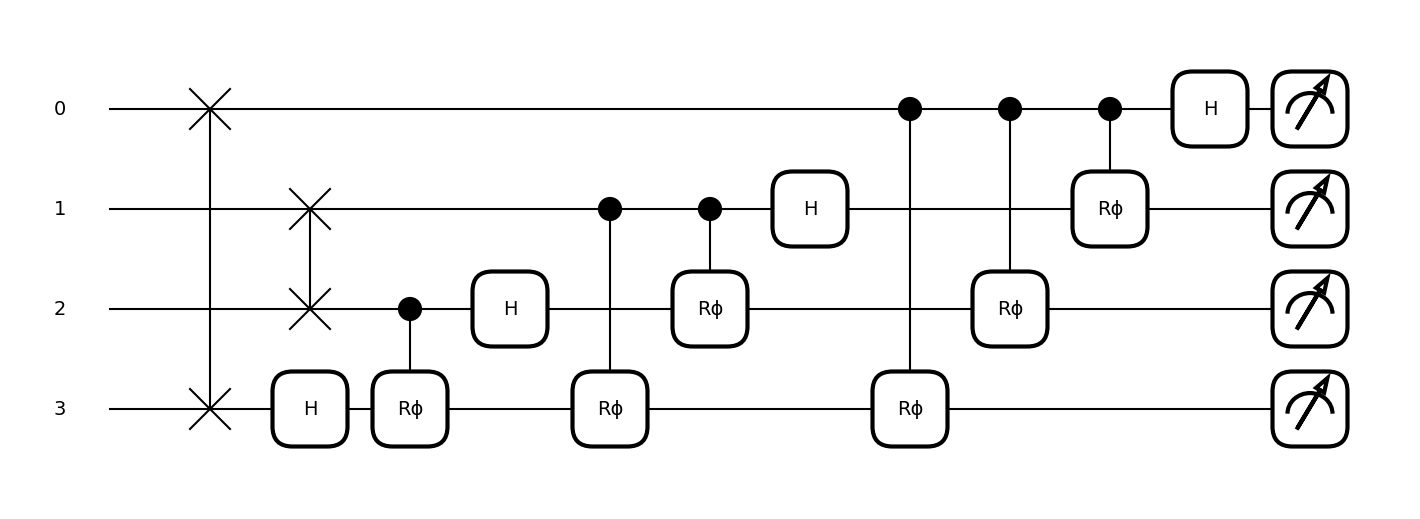

In [24]:
circuit()

print(qml.draw_mpl(circuit)())

In [25]:
def phaseShift(k,n):
    qml.PhaseShift(-2*np.pi/2**k,wires=n)

@qml.qnode(device)
def circuit():

    m = 0
    c = len(device.wires)-1
    for x in range(m,c):
        while m < c:
            qml.SWAP(wires=[m,c])
            m += 1
            c -= 1

    c = len(device.wires)-1

    qml.Hadamard(wires=c)

    for i in range(c-1,-1,-1):
        k = (c-i) + 1
        for j in range(c,i,-1):
            qml.ctrl(phaseShift, control=i)(k,j)
            k -=1
        qml.Hadamard(wires=i)
    
    return qml.sample()


<bound method Figure.show of <Figure size 4000x900 with 1 Axes>>

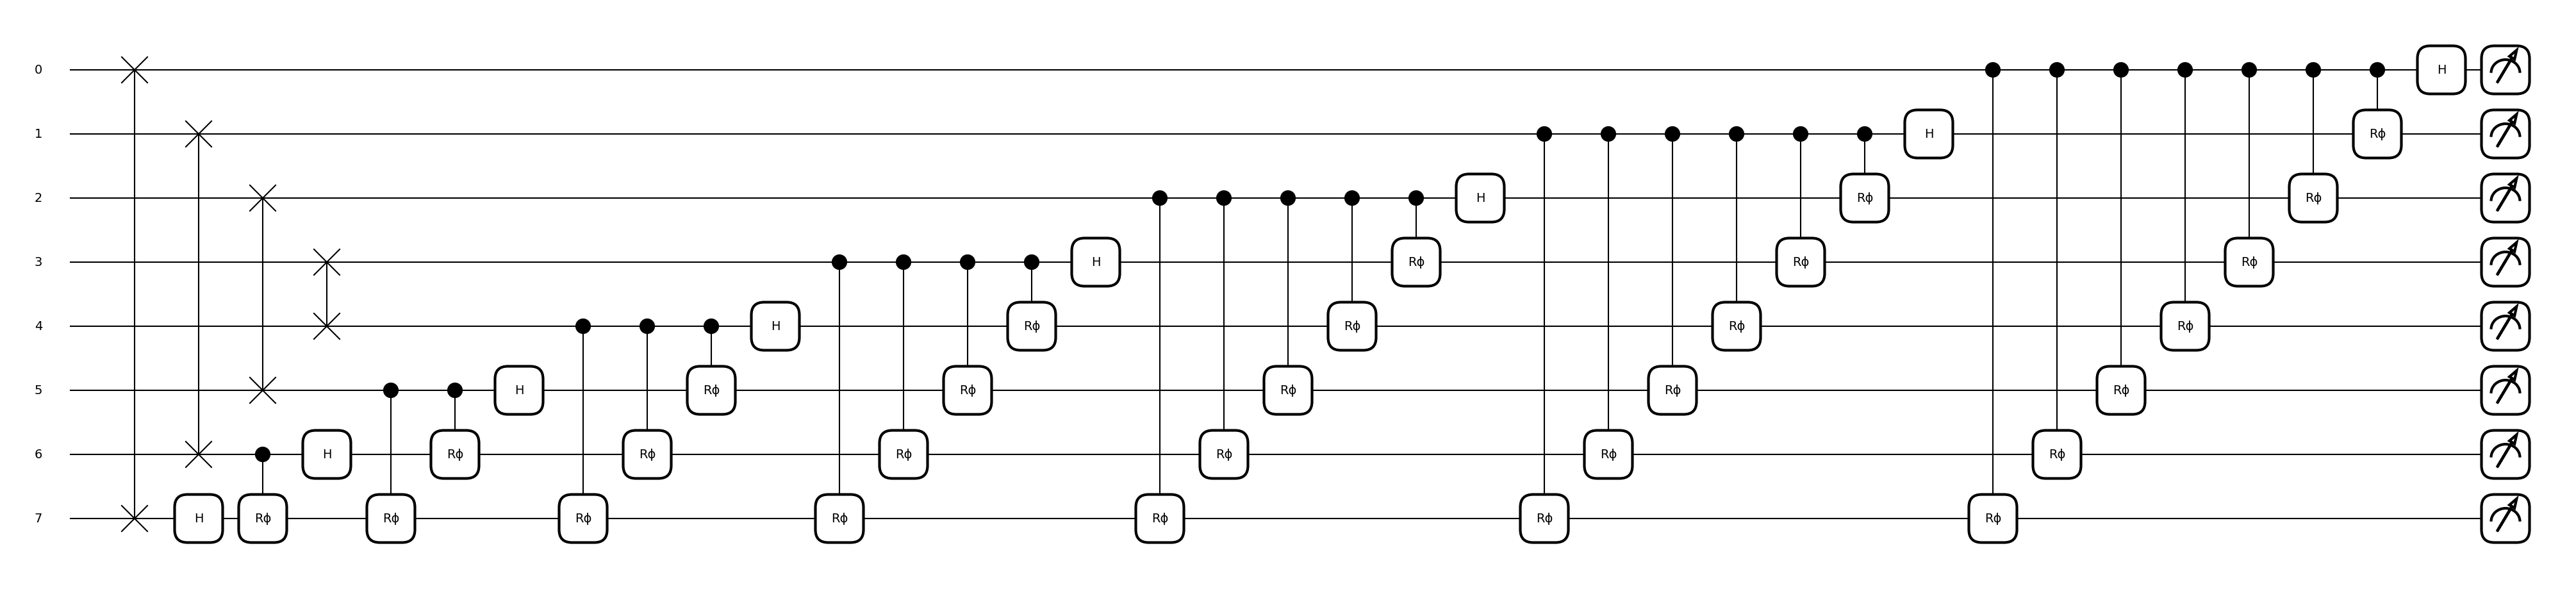

In [26]:
fig, ax = qml.draw_mpl(circuit)()
fig.show

In [27]:
@qml.qnode(device)
def circuit():
    qml.PauliX(wires=3)

    for qubit in range(3):
        qml.Hadamard(wires=qubit)

    repetitions = 1

    for x in range(2,-1,-1):
        for i in range(repetitions):
            qml.ControlledPhaseShift(np.pi/4, wires=[x,3])
        repetitions *= 2

    qml.adjoint(qml.QFT)(wires=[0,1,2])
    return qml.sample(wires=[0,1,2])

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


/var/folders/2d/3vb6hz_s28z4y7mpqyhs8nbw0000gq/T/ipykernel_31166/192742738.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


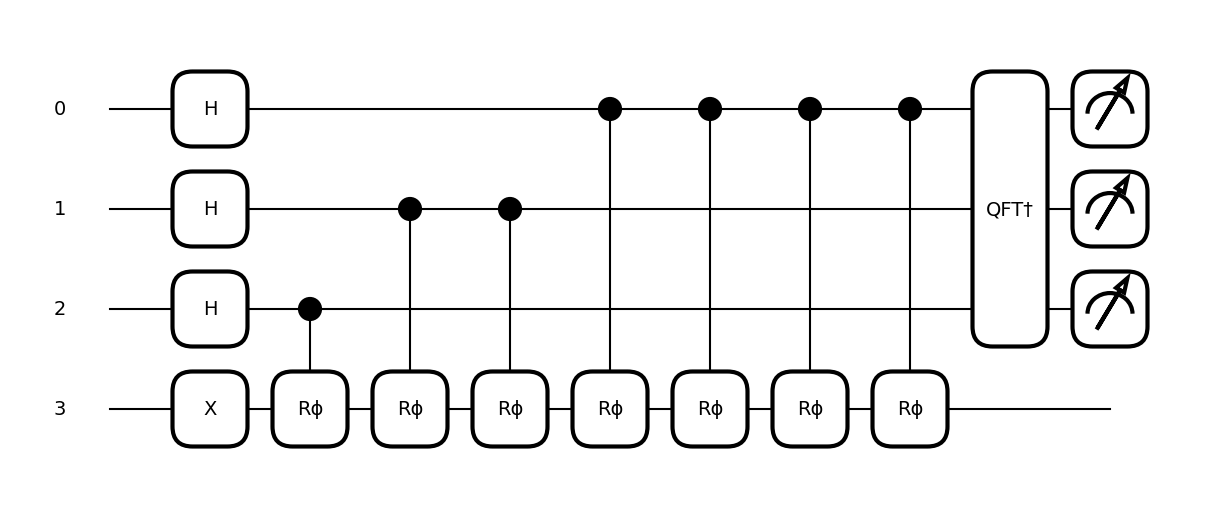

In [28]:
fig, ax = qml.draw_mpl(circuit)()
fig.show()
print(circuit())

In [55]:
def aMod15(qml,a,x, qubits):
    if a not in [2,7,8,11,13]:
        raise ValueError("The base a must be 2,7,8,11, or 13")
    
    for _ in range(4):
        if a in [2,13]:
            qml.SWAP(wires=[qubits[0],qubits[1]])
            qml.SWAP(wires=[qubits[1],qubits[2]])
            qml.SWAP(wires=[qubits[2],qubits[3]])
        if a in [7,8]:
            qml.SWAP(wires=[qubits[2],qubits[3]])
            qml.SWAP(wires=[qubits[1],qubits[2]])
            qml.SWAP(wires=[qubits[0],qubits[1]])
        if a == 11:
            qml.SWAP(wires=[qubits[1],qubits[3]])
            qml.SWAP(wires=[qubits[0],qubits[2]])
        if a in [7,11,13]:
            for qubit in range(4):
                qml.PauliX(wires=qubits[qubit])

# @qml.qnode(device)
def modExp(qml,n,m,a):
    print (n,m,a)
    for x in range (n):
        qml.ctrl(aMod15, control=x)(qml,a, 2**x, [4,5,6,7])
    # return qml.sample(wires=[0,1,2,3])

In [56]:
# @qml.qnode(device)
def inverseQFT(qml, n):
    qml.adjoint(qml.QFT)(wires=range(n))
    # return qml.sample(wires=range(n))

(<Figure size 400x400 with 1 Axes>, <Axes: >)

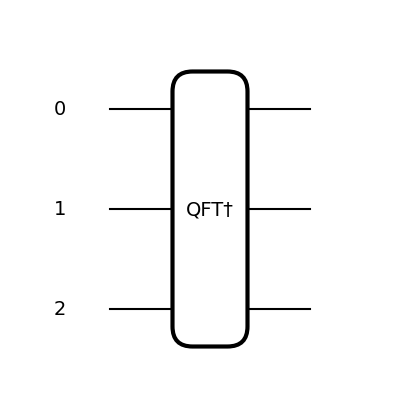

In [57]:
qml.draw_mpl(inverseQFT)(qml, 3)

4 1 7


(<Figure size 11500x900 with 1 Axes>, <Axes: >)

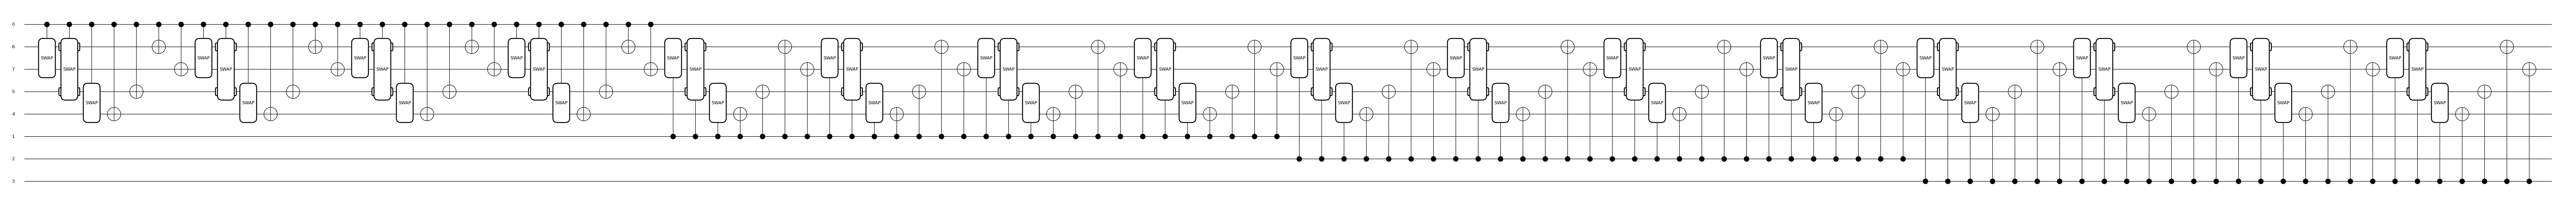

In [58]:
qml.draw_mpl(modExp)(qml, 4,1,7)

In [59]:
@qml.qnode(device)
def shor(n,m,a):
    print (n,m,a)
    for x in range(n):
        qml.Hadamard(wires=x)

    qml.PauliX(wires=n+m-1)

    modExp(qml,n,m,a)

    inverseQFT(qml, n)

    for x in range(n):
        qml.measure(wires=x)

    return qml.sample(wires=range(n))

In [37]:
def aMod15(a,x):
    if a not in [2,7,8,11,13]:
        raise ValueError("a must be 2,7,8,11, or 13")
    qc = QuantumCircuit(4)

    for _ in range(x):
        if a in [2,13]:
            qc.swap(0,1)
            qc.swap(1,2)
            qc.swap(2,3)
        if a in [7,8]:
            qc.swap(2,3)
            qc.swap(1,2)
            qc.swap(0,1)
        if a == 11:
            qc.swap(1,3)
            qc.swap(0,2)
        if a in [7,11,13]:
            for qubit in range(4):
                qc.x(qubit)
    
    qc = qc.to_gate()
    qc.name = "%i^%i mod 15" % (a,x)
    cU = qc.control()
    return cU

def modExp(qc, n,m,a):
    for x in range(n):
        qc.append(aMod15(a,2**x),[x]+ list(range(n,n+m)))

def inverseQFT(qc,n):
    qc.append(QFT(len(n), do_swaps=True).inverse(),n)

def circ(n,m,a):
    print ("a",a)
    print ("n",n)
    print ("m",m)

    qc = QuantumCircuit(n+m,n)
    qc.h(range(n))
    qc.x(n+m-1)

    modExp(qc,n,m,a)

    inverseQFT(qc,range(n))

    qc.measure(range(n),range(n))

    return qc

a 8
n 4
m 4


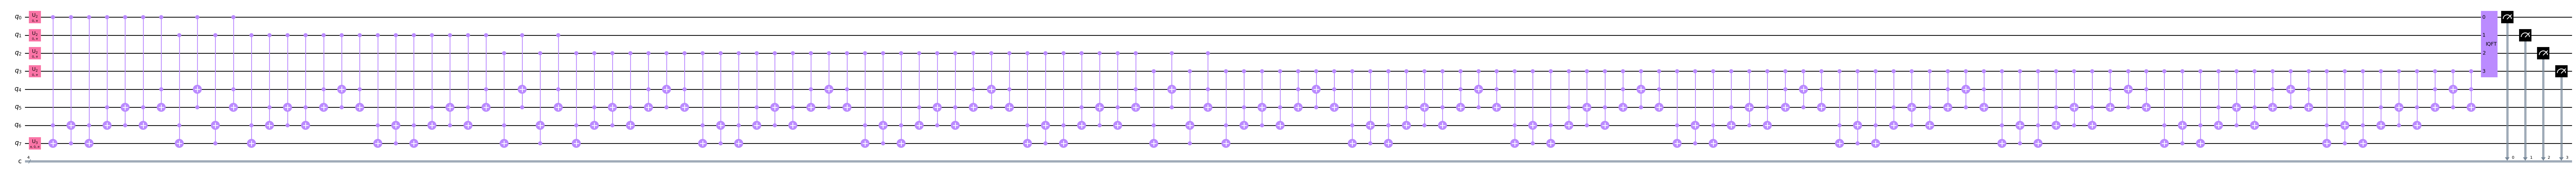

In [44]:
# rewrite the circuits below to use pennylane instead of qiskit
N = 15
a = np.random.randint(2, N)

if math.gcd(a,N) != 1:
    print("a is not coprime to N")
    
n=4
m=4

qc = circ(n,m,a)
qc.decompose().draw(fold=-2, output='mpl')

{'0100': 274, '1000': 241, '0000': 268, '1100': 241}


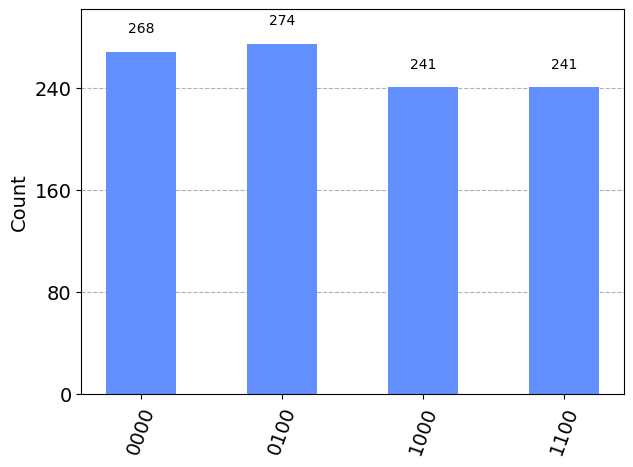

In [60]:
backend = Aer.get_backend('qasm_simulator')
results = qiskit.execute(qc, backend).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

4 4 8
4 4 8
4 4 8
4 4 8
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


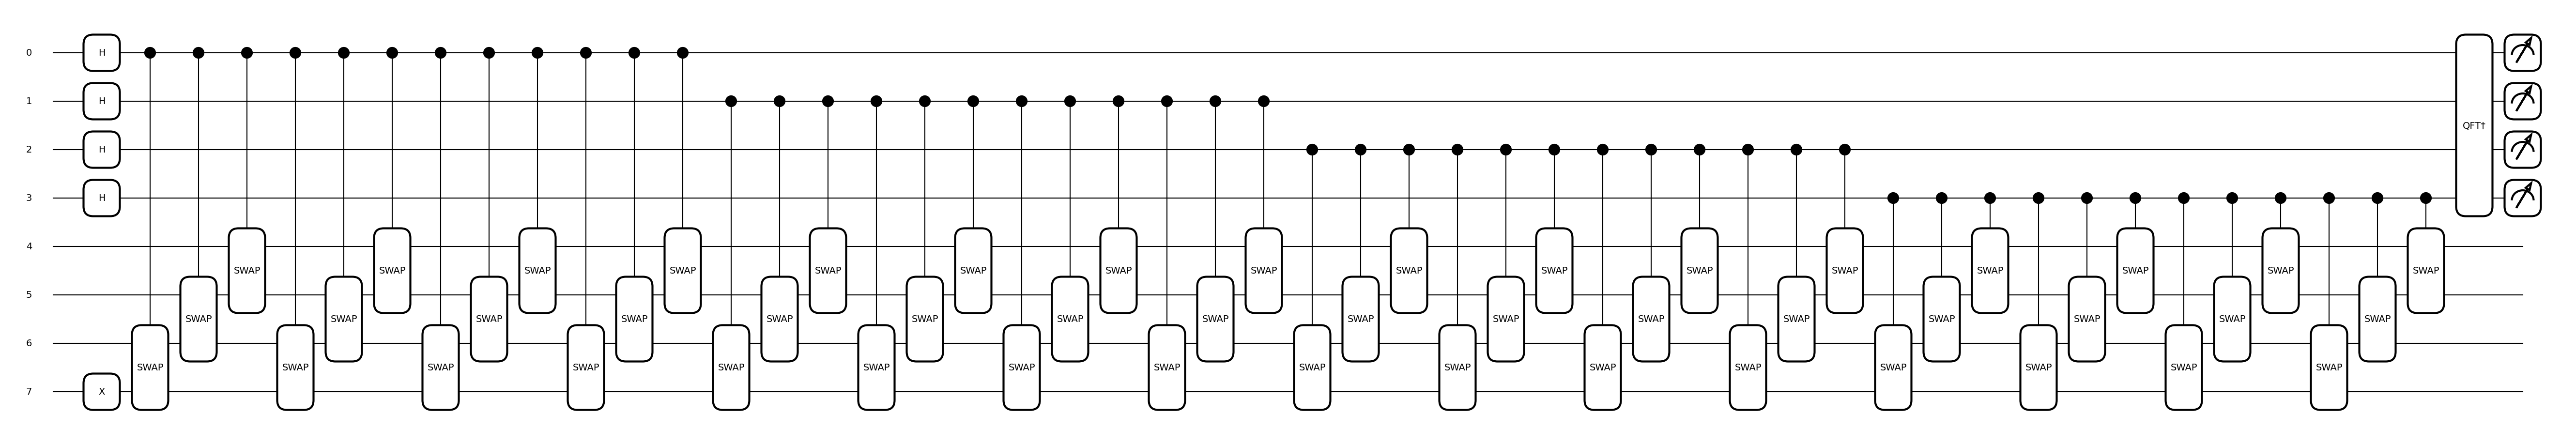

In [66]:
qml.draw_mpl(shor)(n,m,a)


# run the circuit on a quantum simulator
result = shor(n,m,a)

# print the results
print(result)